In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epochs = 20
classes = 10

In [3]:
## get model from asignment 2 and check for acc and other metrices


In [4]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)

train_dataset = datasets.CIFAR10(root="./data", train=True, transform = t, target_transform=target_t, download=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, transform = t, target_transform=target_t, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [6]:
label_names = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog", 
"horse",
"ship",
"truck"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


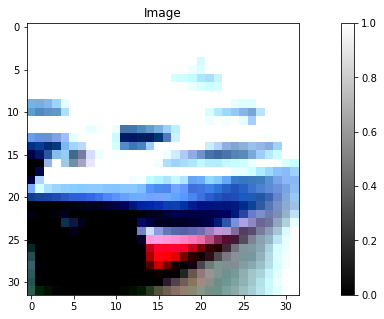

In [7]:
img = next(iter(test_loader))[0][1].permute(1,2,0)
label = next(iter(test_loader))[1][1]
def visual(img):
    img = img / 2 + 0.5
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(label_names[torch.argmax(label)])


In [8]:
class Network(nn.Module):
    """
    This is the CNN architecture to evaluate CIFAR-10 dataset
    """
    def __init__(self):
        super().__init__()
        
#         Input: (3, 32, 32)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#         After Conv1 and maxpool: (6, 14, 14) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

#         After Conv2 and maxpool: (16, 5, 5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [9]:
model = Network()
model.to(device)
summary(model, (3,32,32)) 
#thowing error check

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [10]:
#training 
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 10
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [27]:
def training(EPOCHS=10):
    for epoch in range(EPOCHS):
        running_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for idx, (data, target) in pbar:
            data, target = data.to(device), target.type(torch.FloatTensor).to(device)
            optimizer.zero_grad()
            
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss =+ loss.item()
            
            if idx % 1 == 0:
                pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")
            

In [28]:
training()

Epoch 10, Itr 98, Loss 1.04510: 100%|███████████| 98/98 [00:07<00:00, 12.30it/s]


In [29]:
def testing():
    model.eval()
    total_corr = 0
    preds = []
    labels = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            preds.append(pred)
            labels.append(gt)

            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
    accuracy = (total_corr/len(test_dataset))
    return accuracy, torch.cat(preds), torch.cat(labels)

acc_, preds, labels = testing()

print(f"The Acc of the model is: {acc_ * 100}")

The Acc of the model is: 60.56999588012695
